In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import signal

import warnings
warnings.filterwarnings(action="ignore")

# Set seed for Python's built-in random module
random.seed(42)
# Set seed for NumPy
np.random.seed(42)
# Set seed for TensorFlow/Keras
tf.random.set_seed(42)

In [2]:
from simple_neural_network.nn_model import NNModel
from simple_neural_network.process_xy import Process_XYData

In [3]:
# Reading Pre-processed Data
def read(data_path):
    df = pd.read_csv(data_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.sort_values(by=['Turbine_ID','Timestamp'], inplace=True)
    return df

df = read("./data/all_signals_hourly_processed.csv")

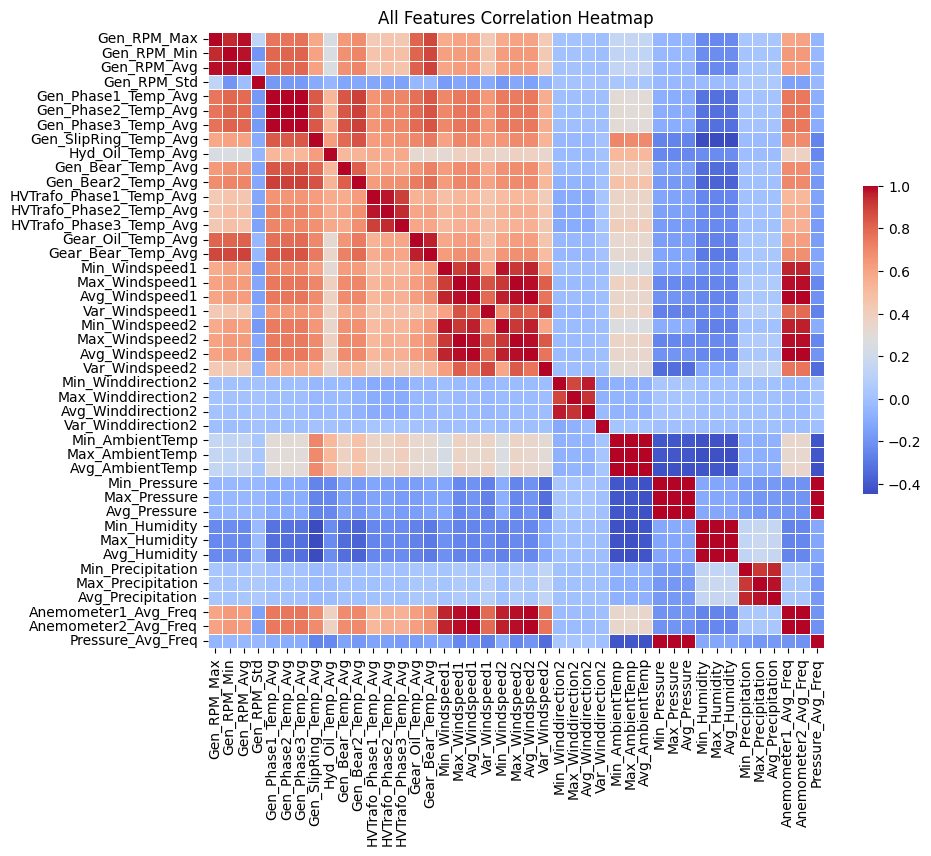

In [4]:
feat = df.iloc[:, 2:-20]

feat_var = feat.var().to_dict()
feat_list = [c for c, var in feat_var.items() if abs(var-0) > 0.001]

plt.figure(figsize=(10, 8))
sns.heatmap(feat[feat_list].corr(), annot=False, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("All Features Correlation Heatmap")
plt.show()

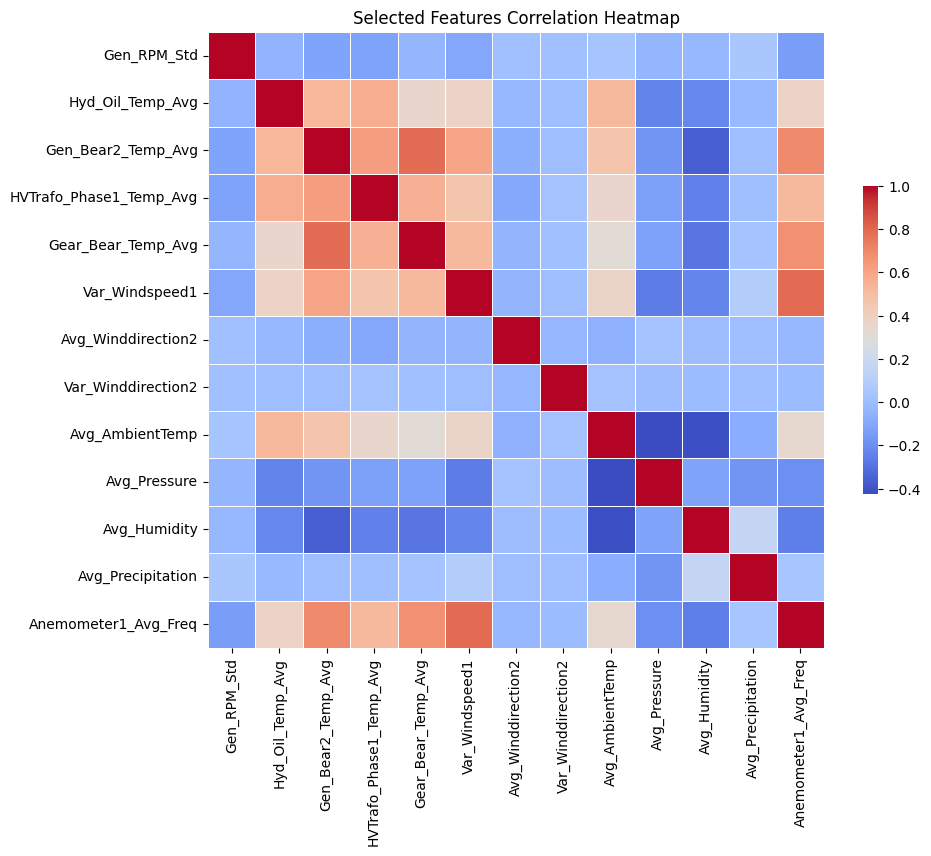

In [5]:
feat_list = [c for c in feat_list if "min" not in c.lower() and "max" not in c.lower()]

corr_matrix = feat[feat_list].corr()
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
# Removing self-correlation (diagonal)
corr_pairs = corr_pairs[corr_pairs['Variable1'] != corr_pairs['Variable2']]
# Removing duplicate pairs
corr_pairs['sorted_row'] = [sorted([a, b]) for a, b in zip(corr_pairs['Variable1'], corr_pairs['Variable2'])]
corr_pairs['sorted_row'] = corr_pairs['sorted_row'].astype(str)
corr_pairs = corr_pairs.drop_duplicates(subset=['sorted_row'])
corr_pairs.drop('sorted_row', axis=1, inplace=True)

high_corr_pairs = corr_pairs[corr_pairs['Correlation'].abs() > 0.8]
features_to_exclude = []
for _, row in high_corr_pairs.iterrows():
    if row['Variable1'] not in features_to_exclude and row['Variable2'] not in features_to_exclude:
        # Strategy: Keep the first feature alphabetically
        feature_to_keep = min(row['Variable1'], row['Variable2'])
        feature_to_exclude = max(row['Variable1'], row['Variable2'])
        features_to_exclude.append(feature_to_exclude)

feat_list = [c for c in feat_list if c not in features_to_exclude]

plt.figure(figsize=(10, 8))
sns.heatmap(feat[feat_list].corr(), annot=False, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Selected Features Correlation Heatmap")
plt.show()

In [6]:
feat_sub = feat[feat_list]
feat_sub = add_constant(feat_sub)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = feat_sub.columns
vif_data["VIF"] = [variance_inflation_factor(feat_sub.values, i) for i in range(feat_sub.shape[1])]
vif_data

,feature,VIF
0,const,54837.293474
1,Gen_RPM_Std,1.065109
2,Hyd_Oil_Temp_Avg,1.885997
3,Gen_Bear2_Temp_Avg,3.967389
4,HVTrafo_Phase1_Temp_Avg,2.031734
5,Gear_Bear_Temp_Avg,3.055493
6,Var_Windspeed1,2.903963
7,Avg_Winddirection2,1.018877
8,Var_Winddirection2,1.003353
9,Avg_AmbientTemp,2.080208


In [7]:
# Keep only selected df with no multicollinearity
df = df[df.iloc[:, :2].columns.to_list() + feat_list + df.iloc[:, -20:].columns.to_list()]

# Linear detrend
# for f in feat_list:
    # df[f] = signal.detrend(df[f]) + df[f].mean()

In [8]:
# Parameters
train_size = 0.8
val_size = 0.2
steps = [24, 3*24, 7*24, 14*24]
subsystem = "GENERATOR_BEARING"

cost = {
    "GEARBOX": {
        "R": 100000,
        "M": 20000,
        "I": 5000,
    },
    "GENERATOR": {
        "R": 60000,
        "M": 15000,
        "I": 5000,
    },
    "GENERATOR_BEARING": {
        "R": 30000,
        "M": 12500,
        "I": 4500,
    },
    "TRANSFORMER": {
        "R": 50000,
        "M": 3500,
        "I": 1500,
    },
    "HYDRAULIC_GROUP": {
        "R": 20000,
        "M": 3000,
        "I": 2000,
    }
}

R, M, I = cost[subsystem].values()

In [9]:
# Train set stop time
time_span = pd.unique(df.sort_values(by='Timestamp')['Timestamp'])
st = time_span[int(len(time_span) * train_size)]
print(f"Training set stop time: {st}")

Training set stop time: 2017-04-23T10:00:00.000000000


In [10]:
# Split training data into X & Y
process = Process_XYData()
df_xy = process.get_XY_with_steps(df, subsystem, None, steps)

In [11]:
# Seperate and save test data for later use
train_xy = df_xy[df_xy['Timestamp'] <= st].reset_index(drop = True)

In [12]:
X_train, Y_train, _, _, _ = process.split_component(train_xy)
X_train, y_train, X_val, y_val = process.balance_and_split(X_train, Y_train, val_size)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((79635, 169), (79635,), (19909, 169), (19909,))

In [13]:
# Create model
nn_model = NNModel(X_train.shape[1])

# Training
nn_model.compile_and_train(X_train, y_train.astype(int), X_val, y_val.astype(int), num_epoch=50)

Epoch 1/50
2489/2489 [==============================] - 4s 1ms/step - loss: 0.0741 - accuracy: 0.9720 - val_loss: 0.0220 - val_accuracy: 0.9976
Epoch 2/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.0108 - val_accuracy: 0.9974
Epoch 3/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0169 - val_accuracy: 0.9954
Epoch 4/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.0138 - val_accuracy: 0.9987
Epoch 5/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0104 - val_accuracy: 0.9965
Epoch 6/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0140 - val_accuracy: 0.9976
Epoch 7/50
2489/2489 [==============================] - 3s 1ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0123 - val_accuracy:

In [14]:
def get_savings(y_true, y_pred, y_event, y_lead, R, M, I):
    FP, FN, TP_lead = 0, 0, []
    warnings = {}
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_true[i] == 1:
            event = y_event[i]
            lead_time = y_lead[i]
            if event not in warnings and y_pred[i] == 0:
                warnings[event] = -1
            elif event not in warnings and y_pred[i] == 1:
                warnings[event] = lead_time
            elif event in warnings and warnings[event] < 0:
                if y_pred[i] == 1:
                    warnings[event] = lead_time
    for event, lead in warnings.items():
        if lead < 0:
            FN += 1
        else:
            TP_lead.append(lead)
    
    savings = 0
    for l in TP_lead:
        savings += (l / 60) * (R - M)
    savings -= FP * I
    savings -= FN * R
    
    return FP, FN, TP_lead, savings

440/440 [==============================] - 0s 863us/step
0 0 [] 0


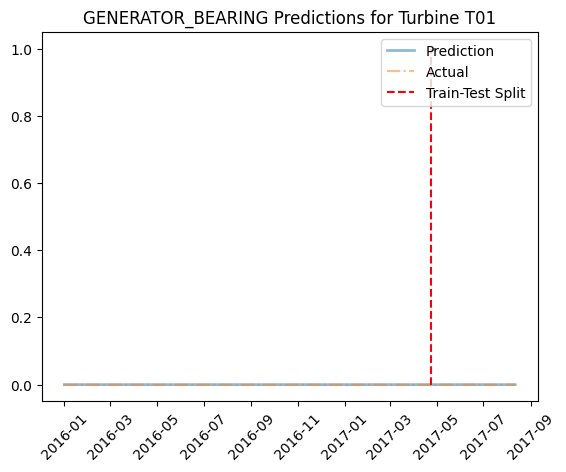

437/437 [==============================] - 0s 752us/step
1 0 [] -4500


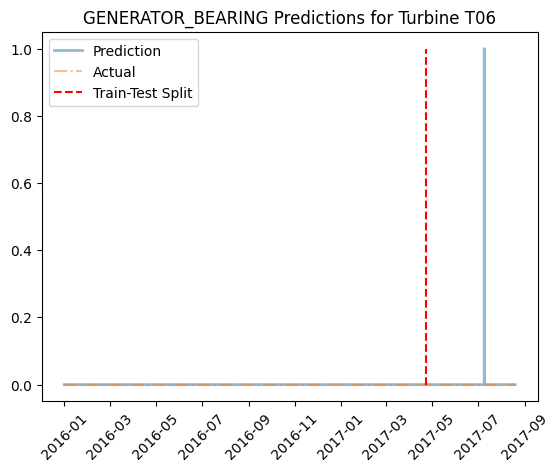

447/447 [==============================] - 0s 810us/step
2 0 [58, 40] 19583.333333333336


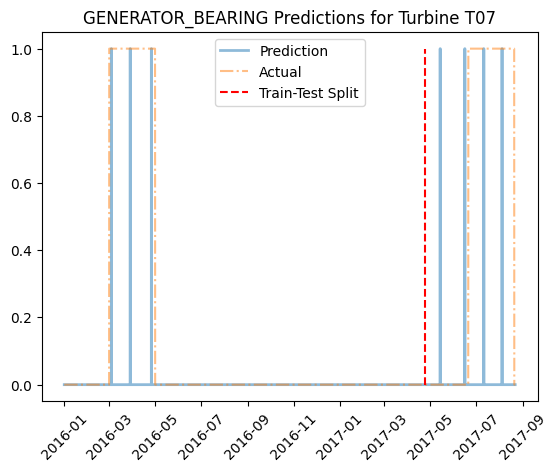

411/411 [==============================] - 0s 801us/step
2 0 [58, 58, 31, 58] 50791.66666666667


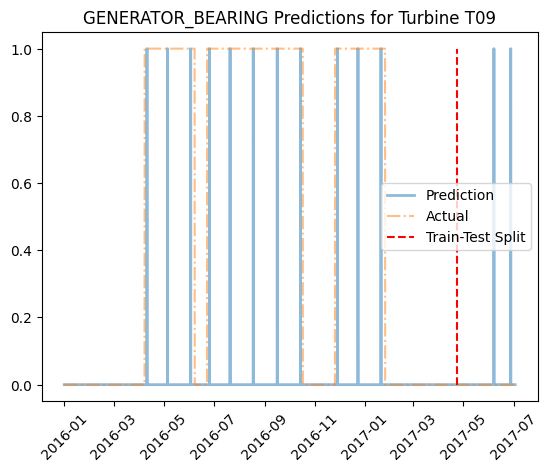

411/411 [==============================] - 0s 771us/step
0 0 [] 0


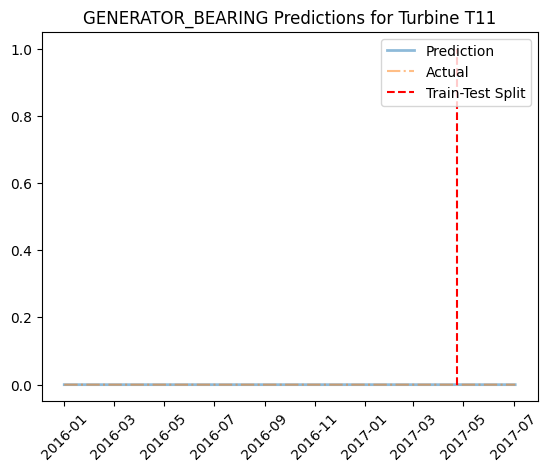

Total Savings: 65875.0


In [27]:
total_savings = 0
for turbine in ['T01','T06','T07','T09','T11']:
    df_sub = df_xy[df_xy['Turbine_ID'] == turbine]
    X_test, Y_test, lead, default, time = process.split_component(df_sub)
    y_pred = nn_model.predict(X_test, threshold=0.9)
    y_true = Y_test.astype(int)
    
    consec_warn = 0
    consec_threshold = 24*3
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            consec_warn += 1
            if consec_warn < consec_threshold:
                y_pred[i] = 0
            elif consec_warn == consec_threshold:
                continue
            elif consec_warn > consec_threshold and consec_warn <= 4*7*24:
                y_pred[i] = 0
            elif consec_warn > 4*7*24:
                consec_warn = 0
        elif y_pred[i] == 0:
            if consec_warn > 0:
                consec_warn = 0
    
    last_warn_time = None
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and last_warn_time is None:
            last_warn_time = time[i]
        elif y_pred[i] == 1 and last_warn_time is not None:
            warn_time = time[i]
            if (warn_time - last_warn_time) / np.timedelta64(1, 'D') <= 2*7:
                y_pred[i] = 0
            else:
                last_warn_time = warn_time

    y_true_df = pd.DataFrame({
        "t": time,
        "y_true": y_true
    }).set_index("t")
    
    y_pred_df = pd.DataFrame({
        "t": time,
        "y_pred": y_pred.reshape(-1)
    }).set_index("t")

    FP, FN, TP_lead, savings = get_savings(y_true, y_pred, default, lead, R, M, I)
    print(FP, FN, TP_lead, savings)
    total_savings += savings

    plt.plot(y_pred_df, linewidth=2, alpha=0.5, label="Prediction")
    plt.plot(y_true_df, ls="-.", alpha=0.5, label="Actual")
    plt.vlines(x=st, ymin=0, ymax=1, ls="--", label="Train-Test Split", color="red")
    plt.title(f"{subsystem} Predictions for Turbine {turbine}")
    plt.legend(loc="best")
    plt.xticks(rotation=45)
    plt.show()

print(f"Total Savings: {total_savings}")